In [29]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.layers import Reshape
from keras.models import Model
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D,ZeroPadding2D
from keras.preprocessing.image import load_img, img_to_array
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy as np
from PIL import Image
import argparse
import math

from keras.applications import VGG16, vgg16
from keras import backend as K
import keras
import matplotlib.pyplot as plt
%matplotlib inline

In [202]:
base_image_path = "GoghSelf.jpg"
train_image_path = "GoghSelfDoodle.jpg"
style_reference_image_path = "GoghSelf.jpg"
dopple_image_path = "GoghDoppleDoodle.jpg"

total_variation_weight = 1.0
style_weight = 1.0
content_weight = 0.025 * 10

width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = 400#int(width * img_nrows / height)

In [203]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img) * 1.0
    img = np.expand_dims(img, axis=0)
#     img = vgg16.preprocess_input(img) 
    return img


# def deprocess_image(x):
#     x = x.reshape((img_nrows, img_ncols, 3))
#     x[:, :, 0] += 103.939
#     x[:, :, 1] += 116.779
#     x[:, :, 2] += 123.68
#     x = x[:, :, ::-1]
#     x = np.clip(x, 0, 255).astype('uint8')
#     return x


base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
train_image = K.variable(preprocess_image(train_image_path))
dopple_image = K.variable(preprocess_image(dopple_image_path))


In [204]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (0, 1, 2)))
    gram = K.dot(features, K.transpose(features))
    return gram

# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image

def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    sLoss = K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
#     print sLoss.eval()
    return sLoss

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
    b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    return K.sum(K.pow(a + b, 1.25))

In [205]:
def get_loss2(y_true, y_pred):
    sty = (style_reference_image)/256.0
    combo =  y_pred#vgg16.preprocess_input (y_pred * 256)
    base = (base_image)/256.0

    input_tensor = K.concatenate([base, sty, combo], axis=0)

    model = vgg16.VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
    print('Model loaded.')

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

    loss = K.variable(0.)
    layer_features = outputs_dict['block4_conv2']
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = content_weight * content_loss(base_image_features, combination_features)

    feature_layers = ['block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1','block5_conv1']
    
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl
   
    loss += total_variation_weight * total_variation_loss(combo)
    return loss 

In [206]:
def get_loss_doodle(y_true, y_pred):
    sty = (style_reference_image)/256.0
    combo =  y_pred #vgg16.preprocess_input (y_pred * 256)
    base = (base_image)/256.0

    input_tensor = K.concatenate([base, sty, combo], axis=0)

    model = vgg16.VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
    print('Model loaded.')

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

    loss = K.variable(0.)
    layer_features = outputs_dict['block4_conv2']
    base_image_features = layer_features[0, :, :, :]
    sty_image_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = content_weight * content_loss(base_image_features, combination_features)

    feature_layers = ['block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1','block5_conv1']
    
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl
   
    loss += total_variation_weight * total_variation_loss(combo)
    return loss 

In [207]:
def get_loss_doodle(y_true, y_pred):
    sty = (style_reference_image)/256.0
    combo =  y_pred #vgg16.preprocess_input (y_pred * 256)
    base = (base_image)/256.0

    input_tensor = K.concatenate([base, sty, combo], axis=0)

    model = vgg16.VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
    print('Model loaded.')

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

    loss = K.variable(0.)
    c_feature_layers = ['block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1','block5_conv1','block4_conv2']

    for layer_name in c_feature_layers:
        layer_features = outputs_dict[layer_name]
        base_image_features = layer_features[0, :, :, :]
        sty_image_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        loss += content_weight * content_loss(base_image_features, combination_features) / 6.0
    
#     layer_features = outputs_dict['block4_conv2']
#     base_image_features = layer_features[0, :, :, :]
#     sty_image_features = layer_features[1, :, :, :]
#     combination_features = layer_features[2, :, :, :]
#     loss = content_weight * content_loss(base_image_features, combination_features)

    feature_layers = ['block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1','block5_conv1']
    
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl
   
    loss += total_variation_weight * total_variation_loss(combo)
    return loss 

In [208]:
# Combine generative layer with VGG layer
inputs = Input(shape=( 224*224*3, ))

# Layer 1
x1 = Dense(5, activation = 'tanh', init = 'glorot_uniform')(inputs)

# Layer 2
x = Dense(64*56*56, activation = 'tanh', init = 'glorot_uniform')(x1)
x = BatchNormalization()(x)
x = Reshape((64, 56, 56))(x)

# Layer 3
x = UpSampling2D(size = (2, 2))(x) 
x = Convolution2D(16, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# # Layer 4
# x = UpSampling2D(size = (2, 2))(x) #shape is (16, 28, 28)
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# # Layer 5
# x = UpSampling2D(size = (4, 4))(x) #shape is (16, 112, 112)
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 6
x = UpSampling2D(size = (2, 2))(x) 
out = Convolution2D(3, 5, 5, border_mode = 'same', activation = 'sigmoid')(x)


#  output shape is (None, 3, 224, 224)
generative_model = Model(input = inputs, output = out)

In [226]:
inputs = Input(shape=( 3, img_nrows,img_ncols, ))

# x = ZeroPadding2D((1,1))(inputs)
x = Convolution2D(16, img_nrows / 10, img_ncols / 10, border_mode = 'same', activation = 'relu')(inputs)

# x = ZeroPadding2D((1,1))(x)
x = Convolution2D(128, 3, 3, border_mode = 'same',activation='relu')(x)
x = MaxPooling2D((2,2), strides=(2,2))(x)

# x = ZeroPadding2D((1,1))(x)
x = Convolution2D(128, 3, 3, border_mode = 'same', activation='relu')(x)
x = Convolution2D(128, 3, 3, border_mode = 'same', activation='relu')(x)
x = Convolution2D(128, 3, 3, border_mode = 'same', activation='relu')(x)
x = Convolution2D(128, 3, 3, border_mode = 'same', activation='relu')(x)

x = MaxPooling2D((2,2), strides=(2,2))(x)


# x = Convolution2D(128, 3, 3, border_mode = 'same', activation='relu')(x)
# x = Convolution2D(128, 3, 3, border_mode = 'same', activation='relu')(x)
# x = MaxPooling2D((2,2), strides=(2,2))(x)

# x = Convolution2D(128, 3, 3, border_mode = 'same', activation='relu')(x)
# x = Convolution2D(128, 3, 3, border_mode = 'same', activation='relu')(x)
# x = MaxPooling2D((2,2), strides=(2,2))(x)



# x = Convolution2D(128, 5, 5, border_mode = 'same', activation='relu')(x)

# x = Convolution2D(16, 3, 3, border_mode = 'same', activation='relu')(x)

# x = Convolution2D(16, 3, 3, border_mode = 'same', activation='relu')(x)

# x = Convolution2D(16, 3, 3, border_mode = 'same', activation='relu')(x)

# x = Convolution2D(16, 3, 3, border_mode = 'same', activation='relu')(x)

# x = Convolution2D(16, 3, 3, border_mode = 'same', activation='relu')(x)

# x = Convolution2D(16, 3, 3, border_mode = 'same', activation='relu')(x)

# x = Convolution2D(16, 3, 3, border_mode = 'same', activation='relu')(x)

# x = Convolution2D(16, 3, 3, border_mode = 'same', activation='relu')(x)




# x = BatchNormalization()(x)

# x = ZeroPadding2D((1,1))(x)
# x = Convolution2D(128, 3, 3, activation='relu')(x)


# x = ZeroPadding2D((1,1))(x)
# x = Convolution2D(128, 3, 3, activation='relu')(x)
# x = BatchNormalization()(x)

# x = MaxPooling2D((2,2), strides=(2,2))(x)

# x = ZeroPadding2D((1,1))(x)
# x = Convolution2D(128, 3, 3, activation='relu')(x)

# x = MaxPooling2D((2,2), strides=(2,2))(x)

# x = ZeroPadding2D((1,1))(x)
# x = Convolution2D(128, 3, 3, activation='relu')(x)



# Layer 3
# x = UpSampling2D(size = (2, 2))(x) 
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)
# x = BatchNormalization()(x)


# # Layer 4
# x = UpSampling2D(size = (2, 2))(x) #shape is (16, 28, 28)
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# # Layer 5
x = UpSampling2D(size = (2, 2))(x) #shape is (16, 112, 112)
x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 6
x = UpSampling2D(size = (2, 2))(x) 
out = Convolution2D(3, 5, 5, border_mode = 'same', activation = 'sigmoid')(x)


#  output shape is (None, 3, 224, 224)
generative_model2 = Model(input = inputs, output = out)

In [227]:
inputs = Input(shape=( 3, img_nrows,img_ncols, ))

vggTmp = vgg16.VGG16(weights='imagenet', include_top=False)

for layer in vggTmp.layers:
    layer.trainable=False

vggNew = Model(input = vggTmp.input, output = vggTmp.layers[13].output)    

x = vggNew(inputs)
# Layer 3
# x = UpSampling2D(size = (2, 2))(x) 
# x = Convolution2D(16, 5, 5, border_mode = 'same', activation = 'tanh')(x)
# x = BatchNormalization()(x)


# Layer 4
# x = UpSampling2D(size = (2, 2))(x) #shape is (16, 28, 28)
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 5
x = UpSampling2D(size = (2, 2))(x) #shape is (16, 112, 112)
x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

x = UpSampling2D(size = (2, 2))(x) #shape is (16, 112, 112)
x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 6
x = UpSampling2D(size = (2, 2))(x) 
out = Convolution2D(3, 5, 5, border_mode = 'same', activation = 'sigmoid')(x)


#  output shape is (None, 3, 224, 224)
generative_model3 = Model(input = inputs, output = out)

In [228]:
generative_model2.summary()
# vgg16.VGG16(weights='imagenet', include_top=False).summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_98 (InputLayer)            (None, 3, 400, 400)   0                                            
____________________________________________________________________________________________________
convolution2d_279 (Convolution2D)(None, 16, 400, 400)  76816       input_98[0][0]                   
____________________________________________________________________________________________________
convolution2d_280 (Convolution2D)(None, 128, 400, 400) 18560       convolution2d_279[0][0]          
____________________________________________________________________________________________________
maxpooling2d_52 (MaxPooling2D)   (None, 128, 200, 200) 0           convolution2d_280[0][0]          
___________________________________________________________________________________________

In [229]:
# # jpgfile = Image.open("vango2.jpg")
# inp = np.array(jpgfile.getdata())
# inp = np.reshape(inp, (3, -1))
# inpY = 1.0 * np.reshape(inp, (1, 3, 224, 224)) 


# jpgfile = Image.open("ucsd.jpg")
# inp = np.array(jpgfile.getdata())
inp = np.asarray(train_image.eval())
print inp.shape
trainX = np.reshape(inp, (1, 3, img_nrows, img_ncols)) / 256.0
trainX2 = np.reshape(trainX, (1, np.product(trainX.shape)))
trainX3 = trainX2
print np.product(trainX.shape)
trainX3 = np.random.rand(1, 150528)

inpY = inpY/256.0
trainX = np.asarray(trainX)
inpY = np.asarray(trainX)

(1, 3, 400, 400)
480000


In [230]:
adam_op = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
generative_model2.compile(loss = get_loss_doodle, optimizer = adam_op)

Model loaded.


Epoch 1/10
1/1 [==============================] - 1s - loss: 6193031.5000
Epoch 2/10
1/1 [==============================] - 0s - loss: 6348335.0000
Epoch 3/10
1/1 [==============================] - 0s - loss: 6085102.0000
Epoch 4/10
1/1 [==============================] - 0s - loss: 6170859.5000
Epoch 5/10
1/1 [==============================] - 0s - loss: 6227089.0000
Epoch 6/10
1/1 [==============================] - 0s - loss: 6033084.0000
Epoch 7/10
1/1 [==============================] - 0s - loss: 6005073.5000
Epoch 8/10
1/1 [==============================] - 0s - loss: 6008009.5000
Epoch 9/10
1/1 [==============================] - 0s - loss: 5987998.0000
Epoch 10/10
1/1 [==============================] - 0s - loss: 5962791.5000
0


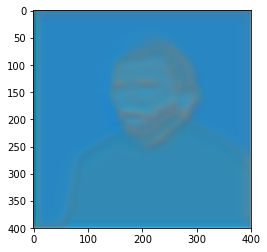

(1, 3, 400, 400)


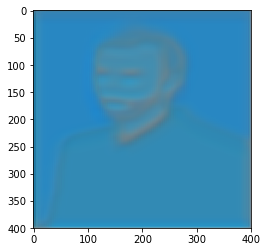

Epoch 1/10
1/1 [==============================] - 0s - loss: 5952896.0000
Epoch 2/10
1/1 [==============================] - 0s - loss: 5926190.5000
Epoch 3/10
1/1 [==============================] - 0s - loss: 5900629.0000
Epoch 4/10
1/1 [==============================] - 0s - loss: 5877977.5000
Epoch 5/10
1/1 [==============================] - 0s - loss: 5830934.5000
Epoch 6/10
1/1 [==============================] - 0s - loss: 5773202.0000
Epoch 7/10
1/1 [==============================] - 0s - loss: 5739774.5000
Epoch 8/10
1/1 [==============================] - 0s - loss: 5702894.0000
Epoch 9/10
1/1 [==============================] - 0s - loss: 5668455.0000
Epoch 10/10
1/1 [==============================] - 0s - loss: 5636562.0000
1


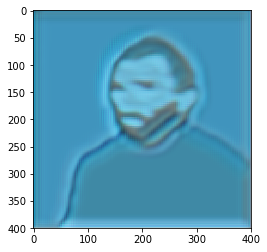

(1, 3, 400, 400)


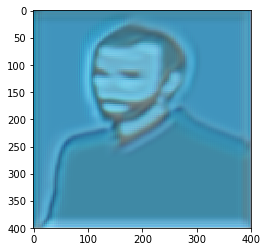

Epoch 1/10
1/1 [==============================] - 0s - loss: 5615457.0000
Epoch 2/10
1/1 [==============================] - 0s - loss: 5590286.0000
Epoch 3/10
1/1 [==============================] - 0s - loss: 5559873.5000
Epoch 4/10
1/1 [==============================] - 0s - loss: 5539349.0000
Epoch 5/10
1/1 [==============================] - 0s - loss: 5497874.5000
Epoch 6/10
1/1 [==============================] - 0s - loss: 5476500.0000
Epoch 7/10
1/1 [==============================] - 0s - loss: 5434812.5000
Epoch 8/10
1/1 [==============================] - 0s - loss: 5407599.5000
Epoch 9/10
1/1 [==============================] - 0s - loss: 5384496.5000
Epoch 10/10
1/1 [==============================] - 0s - loss: 5372625.5000
2


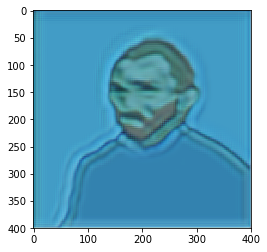

(1, 3, 400, 400)


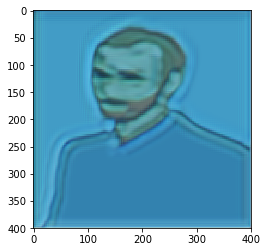

Epoch 1/10
1/1 [==============================] - 0s - loss: 5382980.0000
Epoch 2/10
1/1 [==============================] - 0s - loss: 5357574.5000
Epoch 3/10
1/1 [==============================] - 0s - loss: 5315848.5000
Epoch 4/10
1/1 [==============================] - 0s - loss: 5313522.5000
Epoch 5/10
1/1 [==============================] - 0s - loss: 5272391.0000
Epoch 6/10
1/1 [==============================] - 0s - loss: 5278944.5000
Epoch 7/10
1/1 [==============================] - 0s - loss: 5234078.0000
Epoch 8/10
1/1 [==============================] - 0s - loss: 5228272.0000
Epoch 9/10
1/1 [==============================] - 0s - loss: 5203102.0000
Epoch 10/10
1/1 [==============================] - 0s - loss: 5187702.0000
3


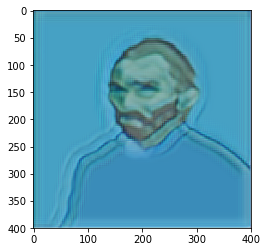

(1, 3, 400, 400)


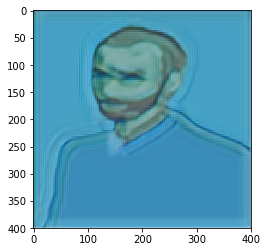

Epoch 1/10
1/1 [==============================] - 0s - loss: 5165191.0000
Epoch 2/10
1/1 [==============================] - 0s - loss: 5145922.5000
Epoch 3/10
1/1 [==============================] - 0s - loss: 5121100.0000
Epoch 4/10
1/1 [==============================] - 0s - loss: 5109979.5000
Epoch 5/10
1/1 [==============================] - 0s - loss: 5092842.0000
Epoch 6/10
1/1 [==============================] - 0s - loss: 5094158.5000
Epoch 7/10
1/1 [==============================] - 0s - loss: 5065822.5000
Epoch 8/10
1/1 [==============================] - 0s - loss: 5045963.5000
Epoch 9/10
1/1 [==============================] - 0s - loss: 5017527.0000
Epoch 10/10
1/1 [==============================] - 0s - loss: 5034137.0000
4


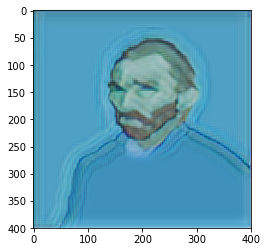

(1, 3, 400, 400)


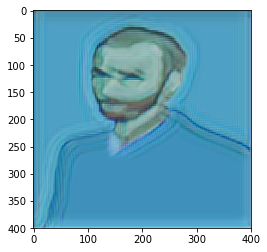

Epoch 1/10
1/1 [==============================] - 0s - loss: 4978279.5000
Epoch 2/10
1/1 [==============================] - 0s - loss: 4975108.0000
Epoch 3/10
1/1 [==============================] - 0s - loss: 4977403.0000
Epoch 4/10
1/1 [==============================] - 0s - loss: 4952068.5000
Epoch 5/10
1/1 [==============================] - 0s - loss: 4955891.0000
Epoch 6/10
1/1 [==============================] - 0s - loss: 4934405.5000
Epoch 7/10
1/1 [==============================] - 0s - loss: 4909888.0000
Epoch 8/10
1/1 [==============================] - 0s - loss: 4877198.0000
Epoch 9/10
1/1 [==============================] - 0s - loss: 4869105.5000
Epoch 10/10
1/1 [==============================] - 0s - loss: 4843802.5000
5


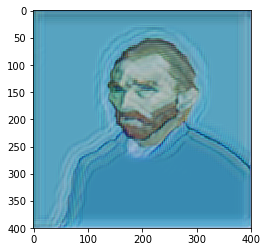

(1, 3, 400, 400)


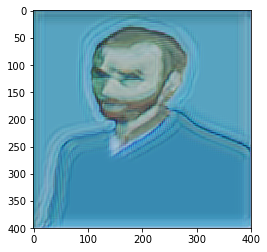

Epoch 1/10
1/1 [==============================] - 0s - loss: 4823109.0000
Epoch 2/10
1/1 [==============================] - 0s - loss: 4804124.0000
Epoch 3/10
1/1 [==============================] - 0s - loss: 4796605.0000
Epoch 4/10
1/1 [==============================] - 0s - loss: 4802508.0000
Epoch 5/10
1/1 [==============================] - 0s - loss: 4826370.5000
Epoch 6/10
1/1 [==============================] - 0s - loss: 4843875.5000
Epoch 7/10
1/1 [==============================] - 0s - loss: 4745772.0000
Epoch 8/10
1/1 [==============================] - 0s - loss: 4776383.0000
Epoch 9/10
1/1 [==============================] - 0s - loss: 4757217.5000
Epoch 10/10
1/1 [==============================] - 0s - loss: 4721854.0000
6


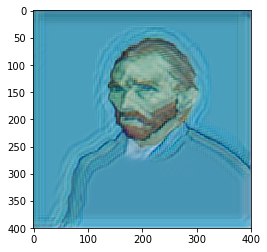

(1, 3, 400, 400)


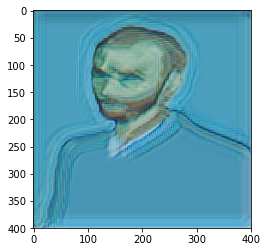

Epoch 1/10
1/1 [==============================] - 0s - loss: 4715399.5000
Epoch 2/10
1/1 [==============================] - 0s - loss: 4716957.0000
Epoch 3/10
1/1 [==============================] - 0s - loss: 4678567.5000
Epoch 4/10
1/1 [==============================] - 0s - loss: 4664983.0000
Epoch 5/10
1/1 [==============================] - 0s - loss: 4647611.0000
Epoch 6/10
1/1 [==============================] - 0s - loss: 4624668.5000
Epoch 7/10
1/1 [==============================] - 0s - loss: 4618680.0000
Epoch 8/10
1/1 [==============================] - 0s - loss: 4593744.5000
Epoch 9/10
1/1 [==============================] - 0s - loss: 4589038.5000
Epoch 10/10
1/1 [==============================] - 0s - loss: 4577484.0000
7


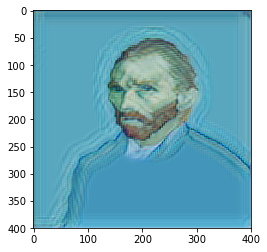

(1, 3, 400, 400)


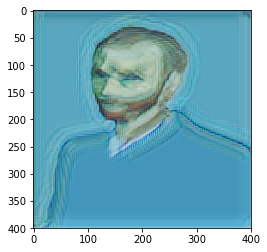

Epoch 1/10
1/1 [==============================] - 0s - loss: 4562551.0000
Epoch 2/10
1/1 [==============================] - 0s - loss: 4539145.0000
Epoch 3/10
1/1 [==============================] - 0s - loss: 4526823.0000
Epoch 4/10
1/1 [==============================] - 0s - loss: 4517249.5000
Epoch 5/10
1/1 [==============================] - 0s - loss: 4500983.5000
Epoch 6/10
1/1 [==============================] - 0s - loss: 4498400.5000
Epoch 7/10
1/1 [==============================] - 0s - loss: 4499220.5000
Epoch 8/10
1/1 [==============================] - 0s - loss: 4532177.5000
Epoch 9/10
1/1 [==============================] - 0s - loss: 4504008.0000
Epoch 10/10
1/1 [==============================] - 0s - loss: 4455512.0000
8


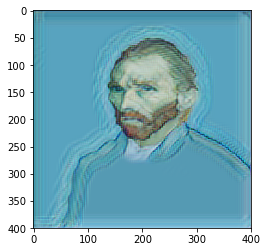

(1, 3, 400, 400)


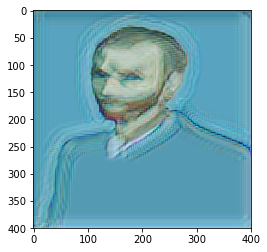

Epoch 1/10
1/1 [==============================] - 0s - loss: 4462316.0000
Epoch 2/10
1/1 [==============================] - 0s - loss: 4466666.5000
Epoch 3/10
1/1 [==============================] - 0s - loss: 4435377.0000
Epoch 4/10
1/1 [==============================] - 0s - loss: 4406399.0000
Epoch 5/10
1/1 [==============================] - 0s - loss: 4417094.0000
Epoch 6/10
1/1 [==============================] - 0s - loss: 4409253.0000
Epoch 7/10
1/1 [==============================] - 0s - loss: 4365397.5000
Epoch 8/10
1/1 [==============================] - 0s - loss: 4380403.5000
Epoch 9/10
1/1 [==============================] - 0s - loss: 4374065.0000
Epoch 10/10
1/1 [==============================] - 0s - loss: 4359949.0000
9


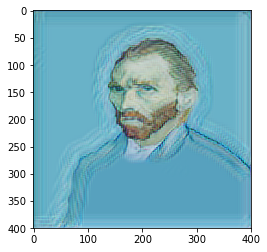

(1, 3, 400, 400)


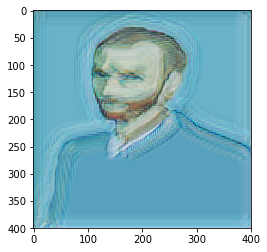

In [231]:
for i in range(10):
    generative_model2.fit(trainX, inpY, nb_epoch = 10, verbose=1)
    img = generative_model2.predict(trainX)
    img = img[0]
    print i
    img = img.swapaxes(0, 2).swapaxes(0, 1)
    plt.imshow(img)
    plt.show()
    inp = np.asarray(dopple_image.eval())
    print inp.shape
    testX = np.reshape(inp, (1, 3, img_nrows, img_ncols)) / 256.0
    # testX2 = np.reshape(testX, (1, np.product(testX.shape)))
    # testX3= testX2
    img = generative_model2.predict(testX)
    # img = generative_model.predict(trainX3)
    img = np.asarray(img[0])
    img = img.swapaxes(0, 2).swapaxes(0, 1)
    plt.imshow(img )
    plt.show()



In [ ]:
# adam_op = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# generative_model3.compile(loss = get_loss_doodle, optimizer = adam_op)

In [ ]:
# for i in range(10):
#     generative_model3.fit(trainX, inpY, nb_epoch = 25, verbose=0)
#     img = generative_model3.predict(trainX)
#     img = img[0]
#     print i
#     img = img.swapaxes(0, 2).swapaxes(0, 1)
#     plt.imshow(img)
#     plt.show()

In [ ]:
img = generative_model2.predict(trainX)
img = np.asarray(img[0])
# print img
img = img.swapaxes(0, 2).swapaxes(0, 1)
plt.imshow(img )
plt.show()

In [ ]:
inp = np.asarray(dopple_image.eval())
print inp.shape
testX = np.reshape(inp, (1, 3, 224, 224)) / 256.0
# testX2 = np.reshape(testX, (1, np.product(testX.shape)))
# testX3= testX2
img = generative_model2.predict(testX)
# img = generative_model.predict(trainX3)
img = np.asarray(img[0])
img = img.swapaxes(0, 2).swapaxes(0, 1)
plt.imshow(img )
plt.show()


In [ ]:
# # generative_model.fit(trainX3, inpY, nb_epoch = 10)
# img = generative_model.predict(trainX3)
# img = img[0]
# print img.shape
# img = img.swapaxes(0, 2).swapaxes(0, 1)
# plt.imshow(img)
# plt.savefig('styletsfr.jpg')
# # plt.show()